In [3]:
import os
import cv2 as cv
import IPython
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import sklearn

In [4]:
folder="D:\DataSet\DataThatWeUse+++\Glaucoma\TRAIN"
#load image from folder as np array
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images
img_array = np.array(load_images_from_folder(folder))

<ipython-input-4-365e1ffd6f43>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  img_array = np.array(load_images_from_folder(folder))


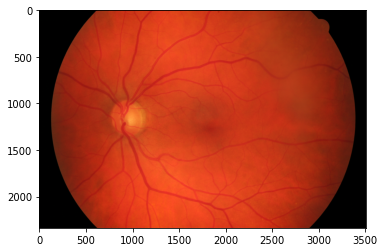

In [46]:
test_img = img_array[4]
#test_img = cv.imread("2420_left.jpg")
plt.imshow(cv.cvtColor(test_img,cv.COLOR_BGR2RGB))

#Define Here for reduce resources



#Blur to remove dust


#Normalize contrast by apply CLAHE
clahe = cv.createCLAHE(clipLimit=2, tileGridSize=(8,8))



#BELOW is ORIGINAL IMAGE

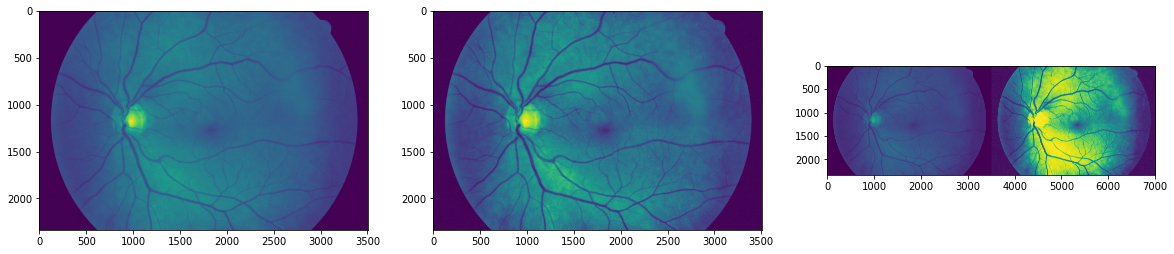

In [47]:
#SHOW G channel
plt.figure(figsize=(20,10))
x1 = plt.subplot(1,3,1)
x2 = plt.subplot(1,3,2)
x3 = plt.subplot(1,3,3)
test_img_test = test_img.copy()
test_img1 = test_img_test[:,:,1] #Green channel
test_img2 = clahe.apply(test_img1) #CLAHE
test_img_blur = cv.GaussianBlur(test_img1,(5,5),0) #try blur

equ = cv.equalizeHist(test_img1) #Try equalizeHist
test_img3 = np.hstack((test_img1,equ))

x1.imshow(test_img_blur)
x2.imshow(test_img2)
x3.imshow(test_img3)


(2336, 3504)


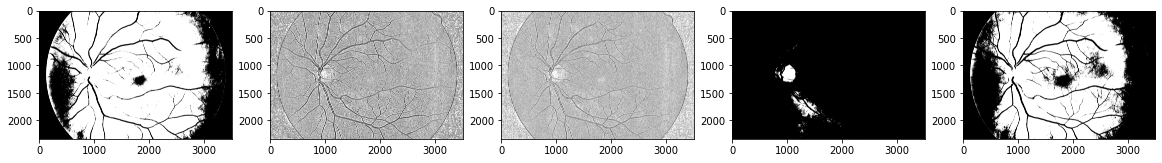

In [60]:
#TEST ALL THRESHOLD in GREEN CHANNEL
plt.figure(figsize=(20,10))
x1 = plt.subplot(1,5,1)
x2 = plt.subplot(1,5,2)
x3 = plt.subplot(1,5,3)
x4 = plt.subplot(1,5,4)
x5 = plt.subplot(1,5,5)

th , test_img_otsu = cv.threshold(test_img2, 0, 255,cv.THRESH_OTSU)
test_img_cmean = cv.adaptiveThreshold(test_img2,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,2)
test_img_gau = cv.adaptiveThreshold(test_img2,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,11,2)
th, test_img_hpix = cv.threshold(test_img2, 128, 255, cv.THRESH_BINARY)
th, test_img_mean = cv.threshold(test_img2, np.mean(test_img2), 255, cv.THRESH_BINARY)

x1.imshow(test_img_otsu,cmap='gray')
print(test_img_otsu.shape)
x2.imshow(test_img_cmean,cmap='gray')
x3.imshow(test_img_gau,cmap='gray')
x4.imshow(test_img_hpix,cmap='gray')
x5.imshow(test_img_mean,cmap='gray')

In [49]:
def ex_blood (img) :
    
    img_b,img_g,img_r = cv.split(img) 
    img_g = cv.GaussianBlur(img_g,(5,5),0)
    img_g = clahe.apply(img_g)
    
    # 3 times open close morph and Amplify the different
    
    open1 = cv.morphologyEx(img_g, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5)), iterations = 3)
    close1 = cv.morphologyEx(open1, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5)), iterations = 3)
    open2 = cv.morphologyEx(close1, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE,(11,11)), iterations = 3)
    close2 = cv.morphologyEx(open2, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE,(11,11)), iterations = 3)
    open3 = cv.morphologyEx(close2, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE,(23,23)), iterations = 3)
    close3 = cv.morphologyEx(open3, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE,(23,23)), iterations = 3)
    ampdif = cv.subtract(close3,img_g)
    amped_img = clahe.apply(ampdif)
    
# removing very small contours through area parameter noise removal
    th,img_bi = cv.threshold(amped_img,15,255,cv.THRESH_BINARY)
    mask = np.ones(amped_img.shape[:2], dtype="uint8") * 255
    temp_img_bi = img_bi.copy()
    contours, hierarchy = cv.findContours(temp_img_bi,cv.RETR_LIST,cv.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv.contourArea(cnt) <= 200:
            cv.drawContours(mask, [cnt], -1, 0, -1)
    temp_img = cv.bitwise_and(amped_img, amped_img, mask=mask)
    th,img_inv_bi = cv.threshold(temp_img,15,255,cv.THRESH_BINARY_INV)
    blood_ves = cv.erode(img_inv_bi, cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3)), iterations=1)
    
    # removing blobs of unwanted bigger chunks taking in consideration they are not straight lines like blood
    #vessels and also in an interval of area
    fundus_eroded = cv.bitwise_not(blood_ves)	
    xmask = np.ones(img.shape[:2], dtype="uint8") * 255
    xcontours, xhierarchy = cv.findContours(fundus_eroded.copy(),cv.RETR_LIST,cv.CHAIN_APPROX_SIMPLE)	
    for cnt in xcontours:
        shape = "unidentified"
        peri = cv.arcLength(cnt, True)
        approx = cv.approxPolyDP(cnt, 0.04 * peri, False)   				
        if len(approx) > 4 and cv.contourArea(cnt) <= 3000 and cv.contourArea(cnt) >= 100:
            shape = "circle"
        else:
            shape = "veins"
        if(shape=="circle"):
            cv.drawContours(xmask, [cnt], -1, 0, -1)

    finalimage = cv.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)	

    return finalimage

def remove_bv(img,blood_vs) :
    remove_ves = cv.inpaint(img,blood_vs,5,cv.INPAINT_TELEA)
    return remove_ves

In [50]:
#### NEED MORE INFO
def detect_roi(img) :
    """If u called remove_bv NO NEED TO NORMALIZE"""
    
    img_b,img_g,img_r = cv.split(img) #split to B-G-R
    #img = cv.GaussianBlur(img,(5,5),0)
    #img = clahe.apply(img_g)
    
    th, img_hpix = cv.threshold(img_g, 99, 255, cv.THRESH_BINARY)
    
    return img_hpix

def rev_od (img) :
    img_b,img_g,img_r = cv.split(img) #split to B-G-R
    th, img_hpix = cv.threshold(img_g, 99, 255, cv.THRESH_BINARY_INV)
    return img_hpix

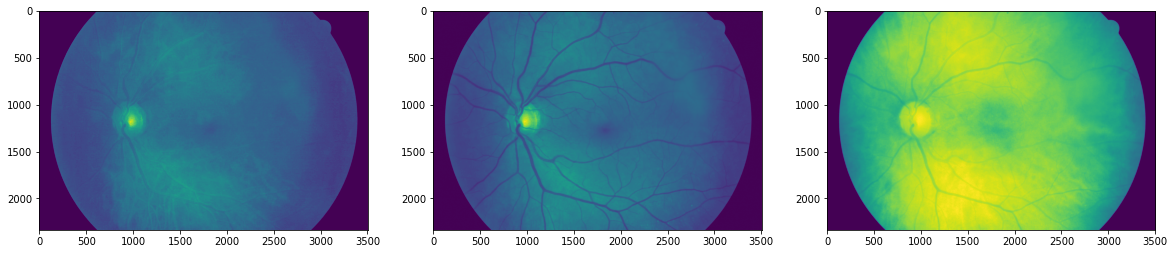

In [51]:
plt.figure(figsize=(20,10))
x1 = plt.subplot(1,3,1)
x2 = plt.subplot(1,3,2)
x3 = plt.subplot(1,3,3)
x1.imshow(test_img[:,:,0]) #B
x2.imshow(test_img[:,:,1]) #G
x3.imshow(test_img[:,:,2]) #R

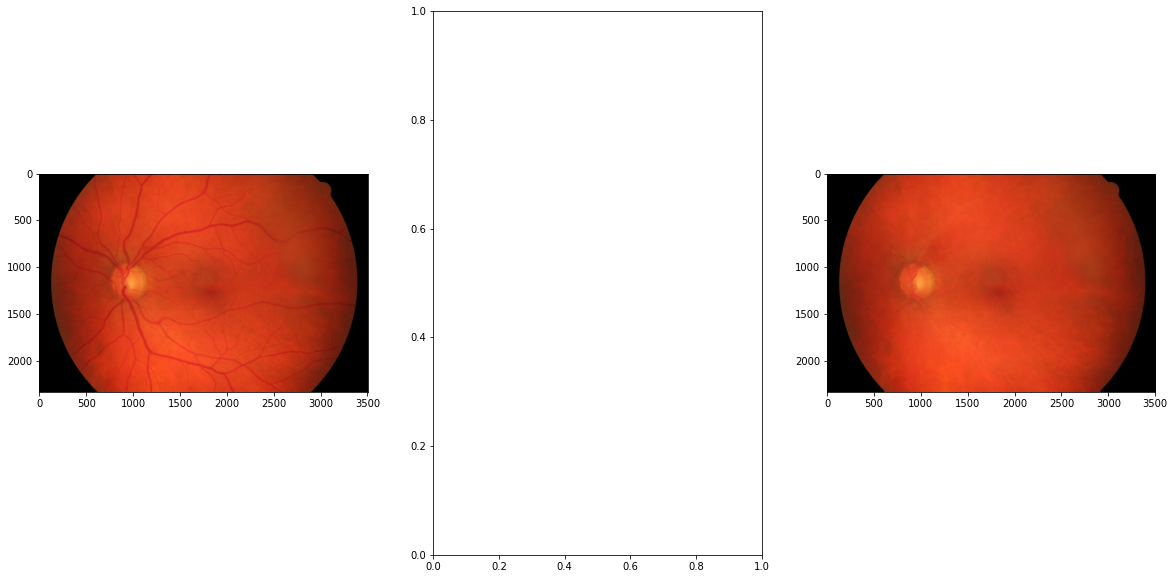

In [52]:
plt.figure(figsize=(20,10))
x1 = plt.subplot(1,3,1)
x2 = plt.subplot(1,3,2)
x3 = plt.subplot(1,3,3)

test_img_nobv = remove_bv(test_img,ex_blood(test_img)) 

x1.imshow(cv.cvtColor(test_img,cv.COLOR_BGR2RGB))
#x2.imshow(ex_blood(test_img),cmap='gray')
x3.imshow(cv.cvtColor(test_img_nobv,cv.COLOR_BGR2RGB))

(2336, 3504)


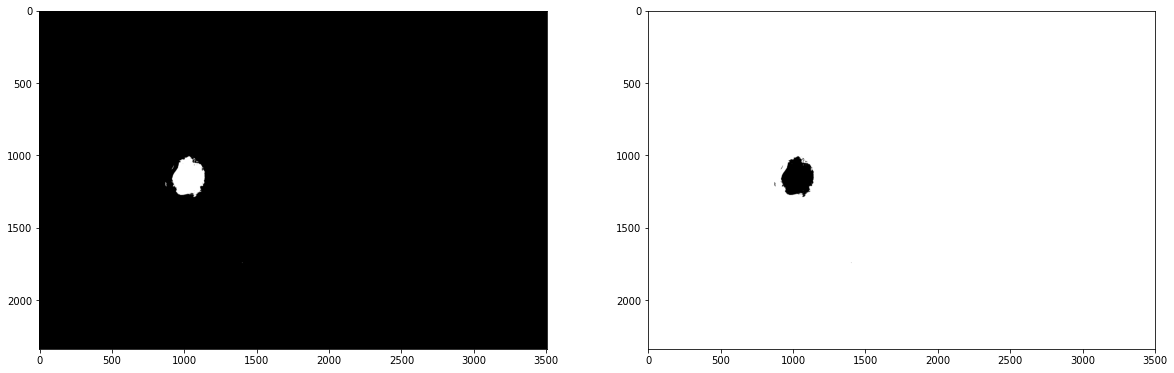

In [53]:
plt.figure(figsize=(20,10))
x1 = plt.subplot(1,2,1)
x2 = plt.subplot(1,2,2)

od = detect_roi(test_img_nobv)
inv_od = rev_od(test_img_nobv)
print(od.shape)
x1.imshow(od,cmap='gray')
x2.imshow(inv_od,cmap='gray')

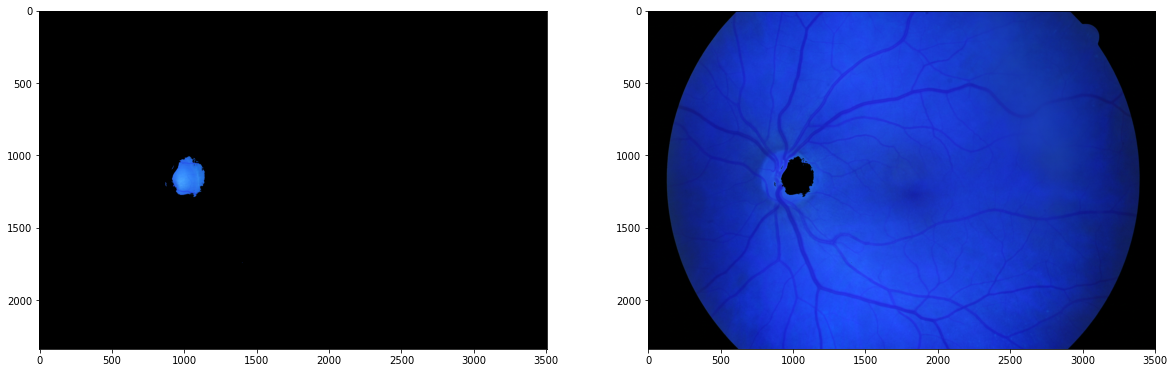

In [54]:
plt.figure(figsize=(20,10))
x1 = plt.subplot(1,2,1)
x2 = plt.subplot(1,2,2)

od_BGR = cv.cvtColor(od,cv.COLOR_GRAY2BGR)
inv_od = cv.cvtColor(inv_od,cv.COLOR_GRAY2BGR)
test1 = cv.bitwise_and(test_img,od_BGR)
test2 = cv.bitwise_and(test_img,inv_od)

x1.imshow(test1)
x2.imshow(test2)

In [55]:
def draw_center(brgimg) :
    
    out_img = brgimg.copy()
    
    gray = cv.cvtColor(brgimg, cv.COLOR_BGR2GRAY)
    
    (minVal, maxVal, minLoc, maxLoc) = cv.minMaxLoc(gray)
    x_cen,y_cen = maxLoc
    max_y,max_x = gray.shape
    
    cv.circle(out_img, maxLoc, 20, (0, 0, 255), 10)
    
    cv.line(out_img, (x_cen, 0), (x_cen, max_y), (0, 255, 0), thickness=2)
    cv.line(out_img, (0, y_cen), (max_x, y_cen), (0, 255, 0), thickness=2)
    
    print("Center is :",maxLoc)
    
    return out_img

def find_center (brgimg) :
    gray = cv.cvtColor(brgimg, cv.COLOR_BGR2GRAY)
    (minVal, maxVal, minLoc, maxLoc) = cv.minMaxLoc(gray)
    return maxLoc

Center is : (979, 1181)
979 1181
3504 2336
0


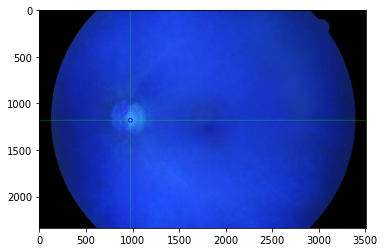

In [56]:
plt.imshow(draw_center(test_img_nobv))

cen_x,cen_y = find_center(test_img_nobv)
print(cen_x,cen_y)
max_y,max_x = od.shape
print(max_x,max_y)
print(od[0,0])

In [57]:
#Return array of Distance from center by use roi from image to calculate radius"distance"
#Format of list : cen2left,cen2right,cen2top,cen2bot

#INPUT no_bv img
def find_rad(brgimg):
    
    cen_x,cen_y = find_center(brgimg)
    bi_roi = detect_roi(brgimg)
    max_y,max_x = bi_roi.shape
    
    #Format is First left ,First right, First upper,First lower,
    first_white = []
    count = 0
    #fix y run x from 0 (left)
    #FIRST LEFT
    for i in bi_roi[cen_y,:] :
        if i == 255 :
            first_white.append(tuple([count,cen_y]))
            count = 0
            break
        count+=1
    
    #FIRST RIGHT
    for i in bi_roi[cen_y,::-1] :
        if i == 255 :
            p_loc = max_x - count
            first_white.append(tuple([p_loc,cen_y]))
            count = 0
            break
        count+=1
    
    #FIRST Top
    for i in bi_roi[::-1,cen_x] :
        if i == 255 :
            p_loc = max_y-count
            first_white.append(tuple([cen_x,p_loc]))
            count = 0
            break
        count+=1
    
    #FIRST Bottom
    for i in bi_roi[:,cen_x] :
        if i == 255 :
            first_white.append(tuple([cen_x,count]))
            count = 0
            break
        count+=1


    cen2left = abs(first_white[0][0] - cen_x)
    cen2right = abs(first_white[1][0] - cen_x)
    cen2top = abs(first_white[2][1] - cen_y)
    cen2bot = abs(first_white[3][1] - cen_y)

    dis_from_cen = np.array(cen2left,cen2right,cen2top,cen2bot)
    
    return dis_from_cen

[63, 160, 93, 146]


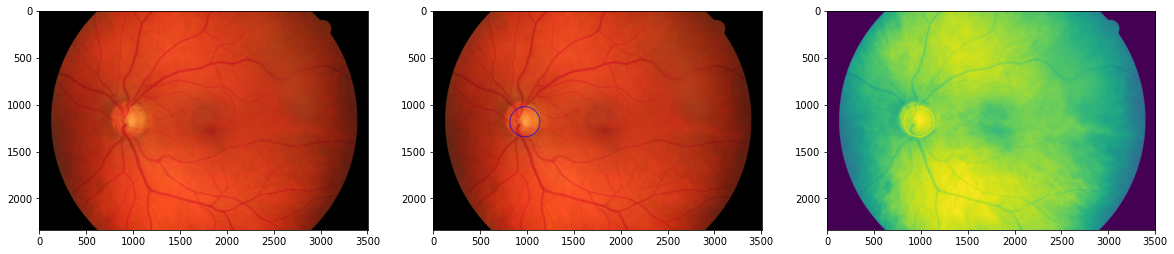

In [58]:
#test find_rad
rad_test = find_rad(test_img_nobv)
print(rad_test)

plt.figure(figsize=(20,10))
x1 = plt.subplot(1,3,1)
x2 = plt.subplot(1,3,2)
x3 = plt.subplot(1,3,3)

test_draw_od = test_img.copy()
test_draw_od = cv.circle(test_draw_od, find_center(test_img_nobv),max(rad_test) , (255, 0, 0), 5)

test_draw_inr = test_img[:,:,2].copy()
test_draw_inr = cv.circle(test_draw_inr, find_center(test_img_nobv),max(rad_test) , (255, 0, 0), 5)



x1.imshow(cv.cvtColor(test_img, cv.COLOR_BGR2RGB))
x2.imshow(cv.cvtColor(test_draw_od, cv.COLOR_BGR2RGB))
x3.imshow(test_draw_inr)